In [1]:
import numpy as np
import pandas as pd

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore') 
#warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

import eli5
from eli5.sklearn import PermutationImportance

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [2]:
#!pip install pystan==2.19.1.1

In [3]:
df = pd.read_csv('Gold1.csv')

In [4]:
df = df.sort_values(by = 'datetime')
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y/%m/%d")

df.index = df['datetime']

df = df.drop('datetime', axis = 1)

df = df['Gold_Price']



In [5]:
df

datetime
1990-01-02     399.60
1990-01-03     394.00
1990-01-04     398.60
1990-01-05     406.30
1990-01-08     403.00
               ...   
2021-04-21    1792.30
2021-04-22    1781.20
2021-04-23    1777.00
2021-04-25    1774.65
2021-04-26    1776.80
Name: Gold_Price, Length: 7969, dtype: float64

In [6]:
df.columns = ['Gold_Price']

df = pd.DataFrame(df)

df

,Gold_Price
datetime,
1990-01-02,399.60
1990-01-03,394.00
1990-01-04,398.60
1990-01-05,406.30
1990-01-08,403.00
...,...
2021-04-21,1792.30
2021-04-22,1781.20
2021-04-23,1777.00


In [7]:
from fbprophet import Prophet

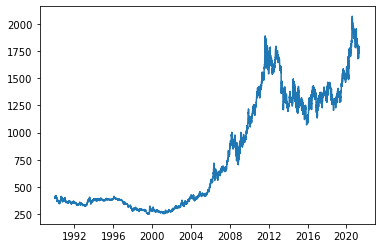

In [8]:
# ARIMA와 같은 데이터로 prophet 모델 학습 시켜보기
model = Prophet()
plt.plot(df)
plt.rcParams["figure.figsize"] = [25, 10]
plt.show()

In [9]:
p_df = pd.DataFrame(list(zip(df.index, df['Gold_Price'])),columns=['ds', 'y'])

In [10]:
p_df

,ds,y
0,1990-01-02,399.60
1,1990-01-03,394.00
2,1990-01-04,398.60
3,1990-01-05,406.30
4,1990-01-08,403.00
...,...,...
7964,2021-04-21,1792.30
7965,2021-04-22,1781.20
7966,2021-04-23,1777.00
7967,2021-04-25,1774.65


In [11]:
# 학습 완료
model.fit(p_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
import pandas as pd

pd.__version__

'1.2.4'

In [13]:
import pystan
pystan.__version__

'2.19.1.1'

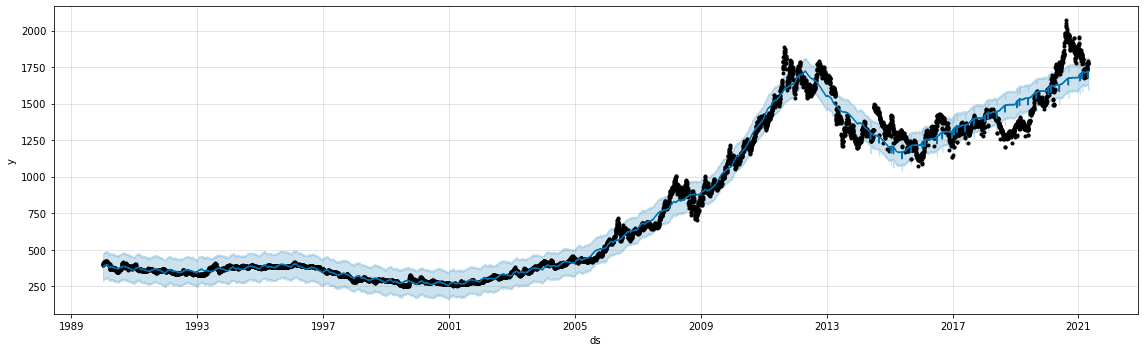

In [14]:
# forecast 에 데이터를 넣고 예측 해보고, 그리고 나서 그래프로 그려봤다
forecast = model.predict(p_df)
fig, ax = plt.subplots(figsize=(16,5))
model.plot(forecast, ax=ax)
plt.show()

In [15]:
forecast[7500:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
7500,2019-07-18,1551.498560,1468.750377,1648.412081,1551.498560,1551.498560,4.149762,4.149762,4.149762,6.018313,6.018313,6.018313,-1.868550,-1.868550,-1.868550,0.0,0.0,0.0,1555.648322
7501,2019-07-19,1551.751062,1468.165601,1636.109959,1551.751062,1551.751062,4.871282,4.871282,4.871282,6.386031,6.386031,6.386031,-1.514750,-1.514750,-1.514750,0.0,0.0,0.0,1556.622343
7502,2019-07-22,1552.508568,1468.345495,1652.323846,1552.508568,1552.508568,5.157684,5.157684,5.157684,5.695562,5.695562,5.695562,-0.537878,-0.537878,-0.537878,0.0,0.0,0.0,1557.666252
7503,2019-07-23,1552.761070,1467.515054,1647.025101,1552.761070,1552.761070,6.296151,6.296151,6.296151,6.534275,6.534275,6.534275,-0.238124,-0.238124,-0.238124,0.0,0.0,0.0,1559.057221
7504,2019-07-24,1553.013573,1467.742932,1651.218568,1553.013573,1553.013573,6.826425,6.826425,6.826425,6.775462,6.775462,6.775462,0.050962,0.050962,0.050962,0.0,0.0,0.0,1559.839997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7964,2021-04-21,1713.857437,1631.236332,1811.902077,1713.857437,1713.857437,6.279230,6.279230,6.279230,6.775462,6.775462,6.775462,-0.496232,-0.496232,-0.496232,0.0,0.0,0.0,1720.136667
7965,2021-04-22,1714.109940,1623.425286,1810.381228,1714.109940,1714.109940,5.432482,5.432482,5.432482,6.018313,6.018313,6.018313,-0.585831,-0.585831,-0.585831,0.0,0.0,0.0,1719.542422
7966,2021-04-23,1714.362442,1630.828669,1813.693719,1714.362442,1714.362442,5.709247,5.709247,5.709247,6.386031,6.386031,6.386031,-0.676784,-0.676784,-0.676784,0.0,0.0,0.0,1720.071689
7967,2021-04-25,1714.867446,1589.969909,1764.549148,1714.867446,1714.867446,-39.721308,-39.721308,-39.721308,-38.855548,-38.855548,-38.855548,-0.865760,-0.865760,-0.865760,0.0,0.0,0.0,1675.146138


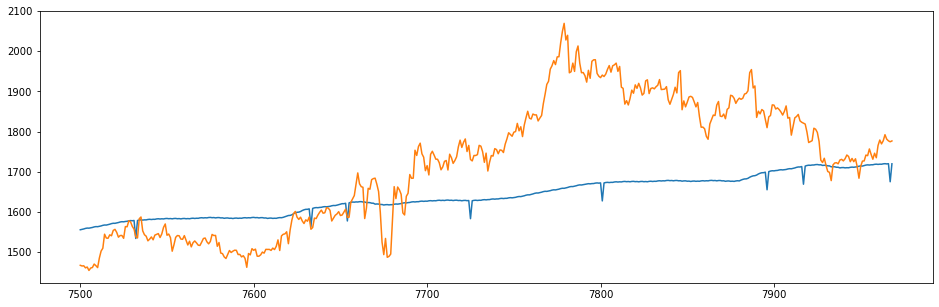

In [16]:
# 주황색이 실제 금 시세
# 파란색이 예측 값 2019 7월 부터 그림

fig, ax = plt.subplots(figsize=(16,5))
plt.plot(forecast['yhat'][7500:])
plt.plot(p_df['y'][7500:])
plt.show()

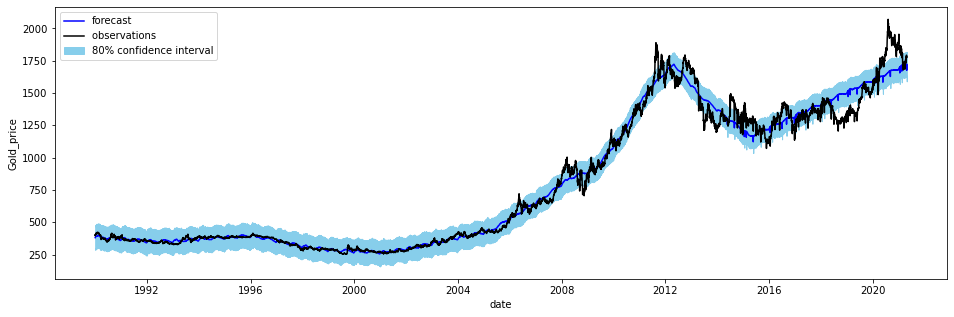

In [17]:
# 데이터 라벨을 붙이면서 다시 그림

fig, ax = plt.subplots(figsize=(16,5))

plt.plot(forecast['ds'].dt.to_pydatetime(),forecast['yhat'], label='forecast', color='blue')
plt.plot(p_df['ds'].dt.to_pydatetime(),p_df['y'], label='observations ', color='black')
plt.fill_between(forecast['ds'].dt.to_pydatetime(), forecast['yhat_upper'],forecast['yhat_lower'],color='skyblue',label='80% confidence interval')
plt.legend()
plt.xlabel('date')
plt.ylabel('Gold_price')
plt.show()

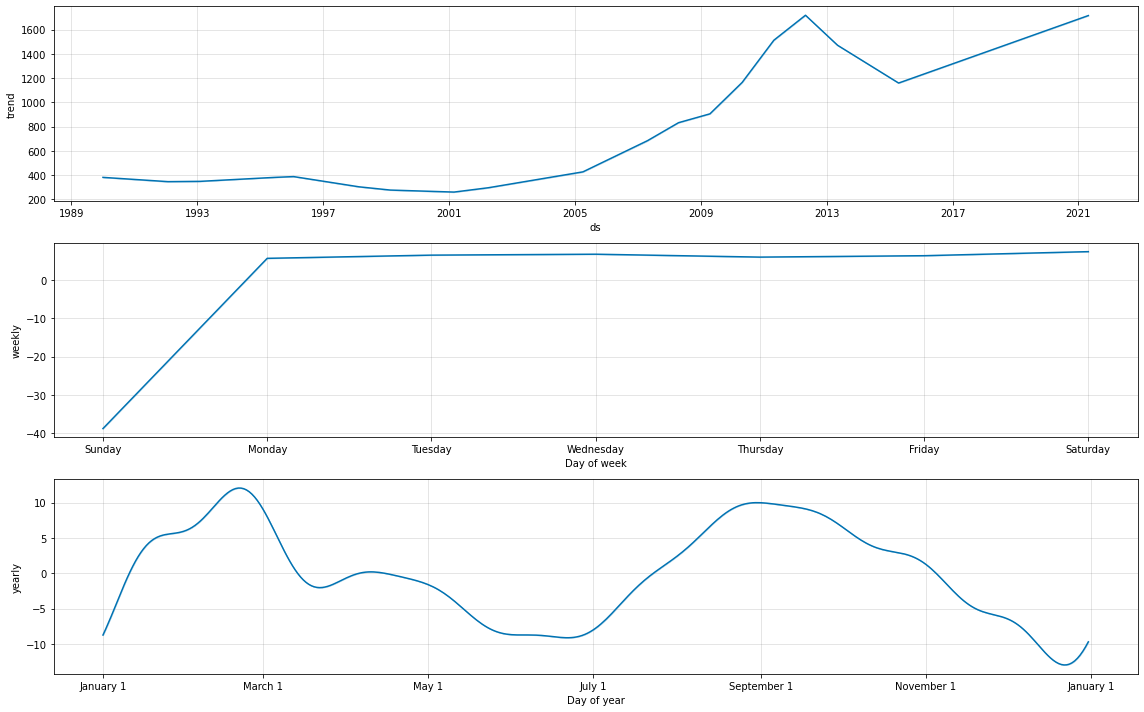

In [18]:
model.plot_components(forecast,figsize=(16,10))
plt.show()

In [19]:
# 미래를 예측할 데이터 만들기
future =  model.make_future_dataframe(periods=365)

In [20]:
future

,ds
0,1990-01-02
1,1990-01-03
2,1990-01-04
3,1990-01-05
4,1990-01-08
...,...
8329,2022-04-22
8330,2022-04-23
8331,2022-04-24
8332,2022-04-25


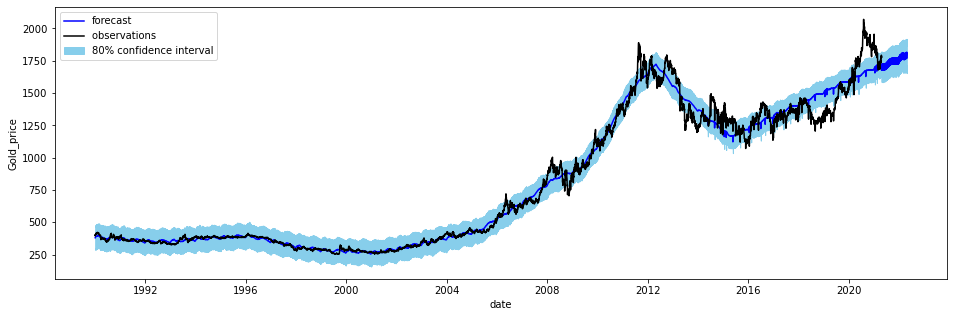

In [21]:
forecast = model.predict(future)
fig, ax = plt.subplots(figsize=(16,5))

plt.plot(forecast['ds'].dt.to_pydatetime(),forecast['yhat'], label='forecast', color='blue')
plt.plot(p_df['ds'].dt.to_pydatetime(),p_df['y'], label='observations ', color='black')
plt.fill_between(forecast['ds'].dt.to_pydatetime(), forecast['yhat_upper'],forecast['yhat_lower'],color='skyblue',label='80% confidence interval')
plt.legend()
plt.xlabel('date')
plt.ylabel('Gold_price')
plt.show()

In [22]:
forecast[forecast['ds'] =='20191231']

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
7619,2019-12-31,1593.413915,1497.922521,1681.07515,1593.413915,1593.413915,-3.532276,-3.532276,-3.532276,6.534275,6.534275,6.534275,-10.066552,-10.066552,-10.066552,0.0,0.0,0.0,1589.881639


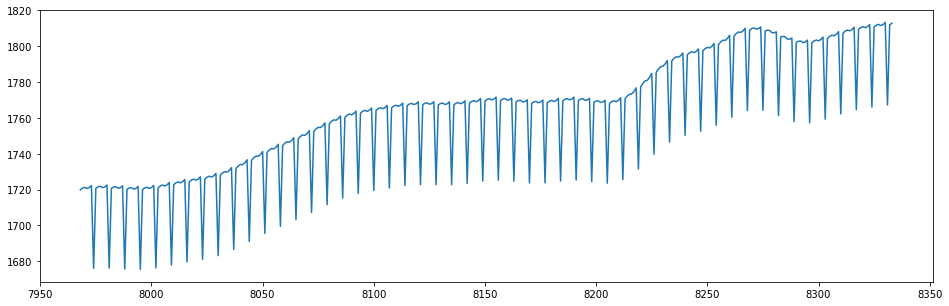

In [23]:
# 파란색이 현재 이후 예측 값 2022 4월 까지 그림

fig, ax = plt.subplots(figsize=(16,5))
plt.plot(forecast['yhat'][7968:])
plt.show()

In [24]:
# model = Prophet(growth = 'logistic')
# p_df['cap'] = 2000
# p_df['floor'] = 250
# model.fit(p_df)
# forecast = model.predict(p_df)
# fig, ax = plt.subplots(figsize=(16,5))
# model.plot(forecast, ax=ax)
# plt.show()

In [25]:
# from fbprophet.plot import add_changepoints_to_plot
# fig = model.plot(forecast)
# a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [26]:
future2 = future[:7969]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


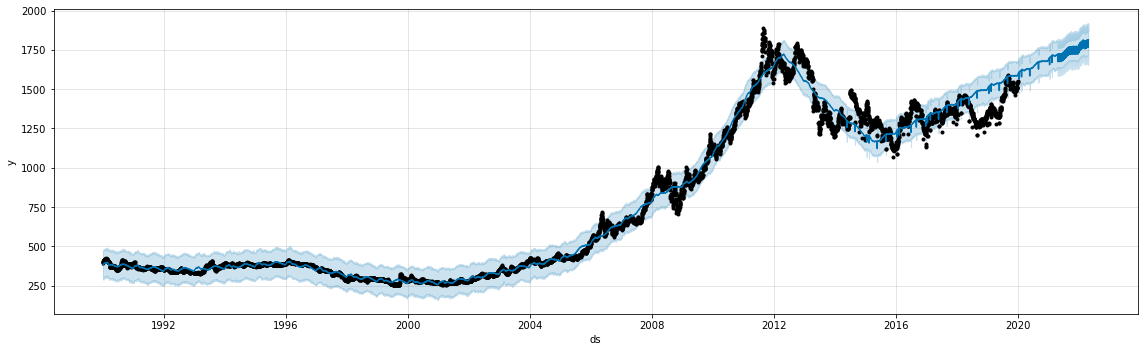

In [27]:
#1990 년부터 2019.12.31 까지 학습 시키고
# 2020년부터 현재까지의 데이터를 예측 시키는 모델 만듬
# 2019.12.31 의 인덱스 값은 7619

import datetime
train, test = p_df[:7620], p_df[7620:]
# forecast 에 학습 데이터를 넣고 예측 해보고, 그리고 나서 그래프로 그려봤다
model2 = Prophet()
model2.fit(train)
forecast2 = model2.predict(future2)
fig, ax = plt.subplots(figsize=(16,5))
model2.plot(forecast, ax=ax)
plt.show()

In [28]:
forecast2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1990-01-02,380.145722,313.420412,450.630018,380.145722,380.145722,0.373405,0.373405,0.373405,9.499213,9.499213,9.499213,-9.125808,-9.125808,-9.125808,0.0,0.0,0.0,380.519128
1,1990-01-03,380.096875,312.832945,445.952648,380.096875,380.096875,1.322503,1.322503,1.322503,9.808689,9.808689,9.808689,-8.486186,-8.486186,-8.486186,0.0,0.0,0.0,381.419378
2,1990-01-04,380.048028,314.617054,449.885775,380.048028,380.048028,1.190668,1.190668,1.190668,8.985458,8.985458,8.985458,-7.794790,-7.794790,-7.794790,0.0,0.0,0.0,381.238695
3,1990-01-05,379.999180,313.224538,448.447600,379.999180,379.999180,2.592525,2.592525,2.592525,9.654192,9.654192,9.654192,-7.061667,-7.061667,-7.061667,0.0,0.0,0.0,382.591705
4,1990-01-08,379.852638,318.261504,451.065537,379.852638,379.852638,3.993971,3.993971,3.993971,8.713071,8.713071,8.713071,-4.719101,-4.719101,-4.719101,0.0,0.0,0.0,383.846609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7964,2021-04-21,1441.196194,1358.635074,1540.774479,1388.086263,1502.150976,7.332201,7.332201,7.332201,9.808689,9.808689,9.808689,-2.476488,-2.476488,-2.476488,0.0,0.0,0.0,1448.528395
7965,2021-04-22,1441.272312,1356.880324,1543.983541,1387.796407,1502.426756,6.565661,6.565661,6.565661,8.985458,8.985458,8.985458,-2.419797,-2.419797,-2.419797,0.0,0.0,0.0,1447.837974
7966,2021-04-23,1441.348430,1356.049545,1538.306228,1387.416289,1502.679512,7.309147,7.309147,7.309147,9.654192,9.654192,9.654192,-2.345045,-2.345045,-2.345045,0.0,0.0,0.0,1448.657577
7967,2021-04-25,1441.500667,1293.197593,1478.274284,1387.035974,1503.185022,-57.637016,-57.637016,-57.637016,-55.474241,-55.474241,-55.474241,-2.162775,-2.162775,-2.162775,0.0,0.0,0.0,1383.863650


In [34]:
from sklearn.metrics import r2_score
print(r2_score(test['y'],forecast2['yhat'][7620:]))

-8.31672082551306


In [35]:
print('검증 RMSE: ', np.sqrt(mean_squared_error(test['y'],forecast2['yhat'][7620:])))

검증 RMSE:  373.2655672729001


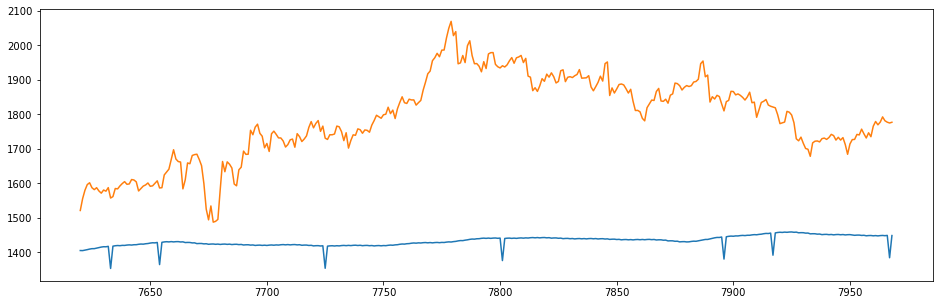

In [36]:
# 파란색이 현재 이후 예측 값 2022 4월 까지 그림

fig, ax = plt.subplots(figsize=(16,5))
plt.plot(forecast2['yhat'][7620:])
plt.plot(test['y'])
plt.show()

In [37]:
from sklearn.metrics import r2_score
print(r2_score(test['y'],forecast2['yhat'][7620:]))

-8.31672082551306
